In [1]:
import os
TRAINING = ["Almost Christmas","Arrival Movie","Batman Telltale","Billy Lynn",
            "Bleed for this","Dishonored 2","Doctor Strange","Edge of Seventeen",
            "Fantastic Beasts","Hacksaw Ridge","Infinite Warfare","Planet Coaster",
            "Pokemon Sun","Trolls Movie","Watch Dogs 2"]

In [2]:
sentimentFilename = os.listdir('../Data/SentiScores')[0]

In [3]:
sentimentDict = {}
with open('../Data/SentiScores/'+sentimentFilename,'r') as f:
    wordsAndScores = f.read().split('\n')
    for pair in wordsAndScores:
        newPair = pair.split("\t")
        sentimentDict[newPair[0]] = int(newPair[1])

In [4]:
#sentimentDict

In [5]:
import pandas as pd
from stop_words import get_stop_words
from nltk.tokenize import RegexpTokenizer

#Change to data folder
#os.chdir('../Data/Tweets')
#Get list of all tweets
filenames = os.listdir('../Data/Tweets')
#Arrays to track each type of metric
names = []
uniquePercent = []
avgPosScore = []
avgNegScore = []
avgUniquePosScore = []
avgUniqueNegScore = []
wordCounts = []
en_stop = get_stop_words('en')
tokenizer = RegexpTokenizer(r'\w+')
#For each filename in the file
for filename in filenames:
    currentWordDoc = {}
    tweet_remove = ['rt','co']
    totalPos = 0.0
    totalNeg = 0.0
    totalUniquePos = 0.0
    totalUniqueNeg = 0.0
    unique = []
    #Get the name of the project
    name = filename.split(".")[0]
    for item in name.lower().split("_"):
        tweet_remove.append(item)
    #Change to a dataframe
    listOfTweets = pd.read_csv('../Data/Tweets/'+filename,header=None)
    #Get total number of tweets in dataset
    totalNum = len(listOfTweets)
    #For each row in the dataframe
    for index, row in listOfTweets.iterrows():
        #Have Variable to check if unique
        isItUnique = False
        #Get the tweet
        tweet = row[0]
        #Set to lower and split the tweet into parts
        tweet_parts = tweet.lower().split(' ')
        tweet_parts = [i for i in tweet_parts if not '@' in i]
        tweet_parts = [i for i in tweet_parts if not 'http' in i]
        tweet_parts = tokenizer.tokenize(' '.join(tweet_parts))
        tweet_parts = [i for i in tweet_parts if not i in en_stop]
        tweet_parts = [i for i in tweet_parts if not i in tweet_remove]
        if tweet_parts not in unique:
            unique.append(tweet_parts)
            isItUnique = True
        for part in tweet_parts:
            if part in sentimentDict:
                if part in currentWordDoc:
                    currentWordDoc[part] += 1
                else:
                    currentWordDoc[part] = 1
                currentScore = sentimentDict[part]
                if currentScore < 0:
                    totalNeg -= currentScore
                    if isItUnique:
                        totalUniqueNeg -= currentScore
                else:
                    totalPos += currentScore
                    if isItUnique:
                        totalUniquePos += currentScore
    names.append(name.replace("_"," "))
    avgPosScore.append(totalPos / float(totalNum))
    avgNegScore.append(totalNeg / float(totalNum))
    uniquePercent.append(float(len(unique))/float(totalNum))
    avgUniquePosScore.append(totalUniquePos/float(len(unique)))
    avgUniqueNegScore.append(totalUniqueNeg/float(len(unique)))
    wordCounts.append(currentWordDoc)
mcScore = [0] * len(names)
with open("../Data/MCScores/MCScores.txt") as scoreFile:
    for line in scoreFile:
        lineArray = line.split(",")
        mcScore[names.index(lineArray[0])] = int(lineArray[1])
dataDF = {'names':names, 'avgPos': avgPosScore, 'avgNeg': avgNegScore, 'unique':uniquePercent, 'mcScore':mcScore,'avgUniquePosScore':avgUniquePosScore,'avgUniqueNegScore':avgUniqueNegScore}
dataDF = pd.DataFrame(dataDF)
print(dataDF)

      avgNeg    avgPos  avgUniqueNegScore  avgUniquePosScore  mcScore  \
0   0.338000  3.867000           0.596591           1.068182       60   
1   0.257000  1.043000           0.336976           1.196721       55   
2   0.371000  3.219000           0.573248           1.735669       81   
3   0.382766  2.589178           0.568000           1.396000       40   
4   0.070000  0.916000           0.208029           0.682482       74   
5   0.235000  0.344000           0.312500           0.640625       52   
6   0.256000  0.993000           0.422179           1.136187       62   
7   0.920000  0.693000           0.509165           1.020367       88   
8   0.326000  1.244000           0.403400           1.367852       72   
9   0.364000  1.199000           0.320370           1.307407       77   
10  0.318000  1.066000           0.356481           1.069444       66   
11  0.248000  1.306000           0.452261           1.105528       86   
12  0.688000  1.180000           0.913131          

In [6]:
from sklearn.linear_model import LinearRegression

trainData = dataDF[dataDF['names'].isin(TRAINING)]

feature_cols = ['avgNeg','avgPos','unique']
x = trainData[feature_cols]
y = trainData['mcScore']
lm = LinearRegression()
lm.fit(x,y)

print lm.intercept_
print lm.coef_

65.6814062418
[ 18.95090068   0.5334336   -3.28495342]


In [25]:
import statsmodels.formula.api as smf
lm = smf.ols(formula='mcScore ~ avgNeg + avgPos + unique', data=trainData).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mcScore   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                 -0.113
Method:                 Least Squares   F-statistic:                    0.5276
Date:                Wed, 30 Nov 2016   Prob (F-statistic):              0.672
Time:                        16:15:22   Log-Likelihood:                -56.670
No. Observations:                  15   AIC:                             121.3
Df Residuals:                      11   BIC:                             124.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     65.6814     15.542      4.226      0.001        31.474    99.889
avgNeg        18.9509     15.846      1.196      0.257       -15.927    53.828
avgPos         0.5334      3.976      0.134      0.896        -8.218     9.285
unique        -3.2850     29.247     -0.112      0.913       -67.658    61.088
==============================================================================
Omnibus:                        1.719   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.116
Skew:                          -0.389   Prob(JB):                        0.572
Kurtosis:                       1.914   Cond. No.                         20.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [10]:
documentMatrix = []
uniqueKeys = []
for count in wordCounts:
    for key in count:
        if key not in uniqueKeys:
            uniqueKeys.append(key)
len(uniqueKeys)

790

In [11]:
i = 0
for count in wordCounts:
    currentVect = [mcScore[i],names[i],avgPosScore[i],avgNegScore[i],uniquePercent[i]]
    i += 1
    for key in uniqueKeys:
        if key in count:
            currentVect.append(count[key])
        else:
            currentVect.append(0)
    documentMatrix.append(currentVect)

In [12]:
documentMatrix[1][0]

55

In [13]:
labels = ["mcScore","names","avgPos","avgNeg","unique"] + uniqueKeys

In [14]:
docMatrixDF = pd.DataFrame(documentMatrix)
docMatrixDF.columns = labels

In [15]:
docMatrixDF

,mcScore,names,avgPos,avgNeg,unique,beautiful,exclusive,liked,terrific,madness,...,improved,improves,rewards,doomed,adore,embarrassing,struggling,abandoned,expand,dodging
0,60,Allied Movie,3.867000,0.338000,0.176000,1,1,23,1,1,...,0,0,0,0,0,0,0,0,0,0
1,55,Almost Christmas,1.043000,0.257000,0.549000,5,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,81,Arrival Movie,3.219000,0.371000,0.314000,3,0,8,2,0,...,0,0,0,0,0,0,0,0,0,0
3,40,Bad Santa 2,2.589178,0.382766,0.501002,2,4,11,0,0,...,0,0,0,0,0,0,0,0,0,0
4,74,Batman Telltale,0.916000,0.070000,0.274000,0,0,58,0,0,...,0,0,0,0,0,0,0,0,0,0
5,52,Billy Lynn,0.344000,0.235000,0.256000,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
6,62,Bleed for this,0.993000,0.256000,0.514000,0,4,5,1,0,...,0,0,0,0,0,0,0,0,0,0
7,88,Dishonored 2,0.693000,0.920000,0.491000,1,0,26,0,0,...,0,0,0,0,0,0,0,0,0,0
8,72,Doctor Strange,1.244000,0.326000,0.647000,9,20,24,0,0,...,0,0,0,0,0,0,0,0,0,0
9,77,Edge of Seventeen,1.199000,0.364000,0.540000,0,5,10,0,3,...,0,0,0,0,0,0,0,0,0,0


In [16]:
docMatrixDF.corr().sort_values(['mcScore'])

,mcScore,avgPos,avgNeg,unique,beautiful,exclusive,liked,terrific,madness,help,...,improved,improves,rewards,doomed,adore,embarrassing,struggling,abandoned,expand,dodging
festive,-0.608677,0.048865,-0.135596,0.277227,0.057282,-0.040773,-0.225554,-0.207312,-1.377643e-01,-0.292604,...,-0.088269,-0.088269,-0.088269,-0.088269,-0.088269,-0.088269,-0.088269,-0.088269,-0.088269,-0.088269
shame,-0.601804,-0.032906,-0.177460,0.146195,-0.200837,0.034337,-0.255062,0.058790,-1.562691e-01,-0.280784,...,-0.100125,-0.100125,-0.100125,-0.100125,-0.100125,-0.100125,-0.100125,-0.100125,-0.100125,-0.100125
united,-0.600494,0.193057,-0.057655,0.143785,0.023947,0.023200,-0.164343,-0.158888,-1.055854e-01,-0.245514,...,-0.067651,-0.067651,-0.067651,-0.067651,-0.067651,-0.067651,-0.067651,-0.067651,-0.067651,-0.067651
wrong,-0.599102,0.061135,-0.095599,-0.244482,-0.131790,-0.102602,0.012317,-0.273261,0.000000e+00,0.092126,...,-0.139618,-0.139618,-0.139618,-0.139618,-0.139618,-0.139618,-0.139618,-0.139618,-0.139618,-0.139618
promise,-0.578098,0.506441,0.020690,-0.069841,-0.085719,0.232283,-0.168905,-0.179605,-1.193525e-01,-0.109329,...,-0.076472,-0.076472,-0.076472,-0.076472,-0.076472,-0.076472,-0.076472,-0.076472,-0.076472,-0.076472
proud,-0.542925,0.203897,-0.032437,0.179085,-0.010179,0.033539,-0.087578,-0.161222,-4.343362e-02,-0.194033,...,-0.077921,-0.077921,-0.077921,-0.077921,-0.077921,-0.077921,-0.077921,-0.077921,-0.077921,-0.077921
celebrate,-0.539044,0.268404,0.010878,0.094066,-0.044169,0.063952,-0.109175,-0.142349,-9.459449e-02,-0.151377,...,-0.060609,-0.060609,-0.060609,-0.060609,-0.060609,-0.060609,-0.060609,-0.060609,-0.060609,-0.060609
greed,-0.528325,0.244979,-0.009164,0.090178,-0.027945,0.056727,-0.121223,-0.123613,-8.214401e-02,-0.191007,...,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632
rage,-0.528325,0.244979,-0.009164,0.090178,-0.027945,0.056727,-0.121223,-0.123613,-8.214401e-02,-0.191007,...,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632
piss,-0.528325,0.244979,-0.009164,0.090178,-0.027945,0.056727,-0.121223,-0.123613,-8.214401e-02,-0.191007,...,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632


<IPython.core.display.Javascript object>


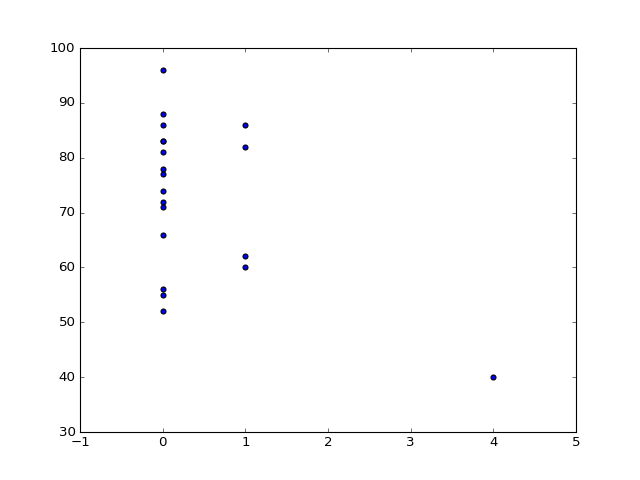

In [17]:
plt.scatter(docMatrixDF["terrible"],docMatrixDF["mcScore"])

In [18]:
import statsmodels.formula.api as smf
lm = smf.ols(formula='mcScore ~ avgNeg + avgPos + unique', data=docMatrixDF).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mcScore   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.144
Date:                Wed, 30 Nov 2016   Prob (F-statistic):              0.361
Time:                        16:12:48   Log-Likelihood:                -79.314
No. Observations:                  20   AIC:                             166.6
Df Residuals:                      16   BIC:                             170.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     72.8099     16.118      4.517      0.000        38.641   106.979
avgNeg        25.6980     17.312      1.484      0.157       -11.002    62.398
avgPos        -4.2359      3.824     -1.108      0.284       -12.343     3.872
unique        -8.2424     30.158     -0.273      0.788       -72.175    55.690
==============================================================================
Omnibus:                        1.414   Durbin-Watson:                   2.352
Prob(Omnibus):                  0.493   Jarque-Bera (JB):                1.245
Skew:                          -0.508   Prob(JB):                        0.537
Kurtosis:                       2.321   Cond. No.                         22.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
docMatrixDF

,mcScore,names,avgPos,avgNeg,unique,beautiful,exclusive,liked,terrific,madness,...,improved,improves,rewards,doomed,adore,embarrassing,struggling,abandoned,expand,dodging
0,60,Allied Movie,3.867000,0.338000,0.176000,1,1,23,1,1,...,0,0,0,0,0,0,0,0,0,0
1,55,Almost Christmas,1.043000,0.257000,0.549000,5,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,81,Arrival Movie,3.219000,0.371000,0.314000,3,0,8,2,0,...,0,0,0,0,0,0,0,0,0,0
3,40,Bad Santa 2,2.589178,0.382766,0.501002,2,4,11,0,0,...,0,0,0,0,0,0,0,0,0,0
4,74,Batman Telltale,0.916000,0.070000,0.274000,0,0,58,0,0,...,0,0,0,0,0,0,0,0,0,0
5,52,Billy Lynn,0.344000,0.235000,0.256000,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
6,62,Bleed for this,0.993000,0.256000,0.514000,0,4,5,1,0,...,0,0,0,0,0,0,0,0,0,0
7,88,Dishonored 2,0.693000,0.920000,0.491000,1,0,26,0,0,...,0,0,0,0,0,0,0,0,0,0
8,72,Doctor Strange,1.244000,0.326000,0.647000,9,20,24,0,0,...,0,0,0,0,0,0,0,0,0,0
9,77,Edge of Seventeen,1.199000,0.364000,0.540000,0,5,10,0,3,...,0,0,0,0,0,0,0,0,0,0


In [20]:
test = ["Trolls Movie","Pokemon Sun"]
dataDF[dataDF["names"].isin(test)]

,avgNeg,avgPos,avgUniqueNegScore,avgUniquePosScore,mcScore,names,unique
17,0.420,2.055,0.482759,1.294253,86,Pokemon Sun,0.435
18,0.424,3.434,0.482759,2.396552,56,Trolls Movie,0.348


In [21]:
dataDF

,avgNeg,avgPos,avgUniqueNegScore,avgUniquePosScore,mcScore,names,unique
0,0.338000,3.867000,0.596591,1.068182,60,Allied Movie,0.176000
1,0.257000,1.043000,0.336976,1.196721,55,Almost Christmas,0.549000
2,0.371000,3.219000,0.573248,1.735669,81,Arrival Movie,0.314000
3,0.382766,2.589178,0.568000,1.396000,40,Bad Santa 2,0.501002
4,0.070000,0.916000,0.208029,0.682482,74,Batman Telltale,0.274000
5,0.235000,0.344000,0.312500,0.640625,52,Billy Lynn,0.256000
6,0.256000,0.993000,0.422179,1.136187,62,Bleed for this,0.514000
7,0.920000,0.693000,0.509165,1.020367,88,Dishonored 2,0.491000
8,0.326000,1.244000,0.403400,1.367852,72,Doctor Strange,0.647000
9,0.364000,1.199000,0.320370,1.307407,77,Edge of Seventeen,0.540000
